# 🧠 3D Brain Tumor Segmentation & Visualization (BraTS2020 Project)

### Project Overview

This notebook is part of an end-to-end brain tumor segmentation project using 3D MRI scans from the **BraTS2020 Validation Dataset**. 

The goal is to explore, preprocess, visualize, and ultimately prepare this data for use in a deep learning model (e.g., 3D U-Net).

Each folder represents a **single subject** and contains 3D MRI scans in the four standard modalities:

| Modality | Description |
|----------|-------------|
| `T1`     | Structural baseline scan (anatomy) |
| `T1ce`   | T1 with contrast agent (highlights tumors) |
| `T2`     | Highlights fluid (CSF, edema) |
| `FLAIR`  | Suppresses CSF and highlights lesions/edema |


Glossary of medical terms used - 
- modality: MRI modalities involve varying the parameters of the magnetic field and radiofrequency pulses to generate different contrast in the images. Each modality is sensitive to different properties of tissues, allowing radiologists to visualize various aspects of anatomy and pathology. In this case the different Madalities will result in contrasts between the brain matter / tissue, allowing us to visualise the Cancerous cells. 

### Project Status (WIP)

| Component                          | Status      | Notes |
|-----------------------------------|-------------|-------|
| Data loading                      |  Done      | Using BraTS2020 Validation set |
| FLAIR normalization + preview     |  Done      | Subsampled and plotted in 3D |
| Modality EDA                |  In Progress | Histograms and anatomical slice views implemented |
| 3D Volume rendering (dense)       |  WIP       | Optional for deep-dive visual inspection |
| Segmentation modeling prep        |  Planned   | Awaiting training set (with masks) |
| Evaluation metrics + overlays     |  Planned   | Will use Dice or IoU once labels are present |
| Narrative + clinical framing      |  Ongoing   | Being developed for interview storytelling and clarity |



# Section 1: Data Loading & Preprocessing

### Step 1.1: Import Libraries
We load all necessary Python libraries to work with 3D medical imaging, including file handling, numerical processing, and visualization.

In [40]:
# Basic Imports and Setup
#!/usr/bin/env python3

import os

import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

import warnings
warnings.filterwarnings("ignore")

#make plots inline for Jupyter
%matplotlib inline

### Step 1.2: Define Data Path and Load NIfTI File

We load a FLAIR modality MRI volume using nibabel, and convert it into a NumPy array for analysis and visualization. We also extract the affine matrix, which contains spatial information about the image in real-world coordinates (e.g. mm in scanner space).


In [41]:
# Define sample FLAIR file path (can later generalize to load all modalities)
sample_id = "BraTS20_Validation_001"
modality = "flair"
# modality = "t1"
# modality = "t1ce"
# modality = "t2"
data_dir = "../data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

# Check if the data directory exists
nii_file = os.path.join(data_dir, sample_id, f"{sample_id}_{modality}.nii")

# Load NIfTI file using nibabel
img = nib.load(nii_file)
data = img.get_fdata()
affine = img.affine

# Diagnostics on the file etc. 
print(f"Shape: {data.shape}")
print(f"Voxel intensity range: {np.min(data):.2f} to {np.max(data):.2f}")


Shape: (240, 240, 155)
Voxel intensity range: 0.00 to 872.00


### Step 1.3: Normalize Intensities to [0, 1]

MRI scans can have wildly different intensity ranges depending on the scanner, patient, and sequence. We scale voxel values to the [0, 1] range using min-max normalization, both for interpretability and performance.

This step wasn’t something i was struggling with for a while — I had to test multiple workbooks and approaches to find a clean solution. It’s also a good reminder of how data preparation directly affects UX when visualizing or modeling.

This step standardizes brightness values, which:
- Helps machine learning models generalize better
- akes visualizations more comparable across scans
- Avoids crashing or freezing from trying to plot extreme intensity spikes (as I discovered when testing on my M1 chip!)

In [42]:
# Normalize the volume data function 

def normalize_volume(volume):
    return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

normalized_data = normalize_volume(data)

print(f"Normalized range: {np.min(normalized_data):.2f} to {np.max(normalized_data):.2f}")


Normalized range: 0.00 to 1.00


### Step 1.4: Threshold and Subsample

We remove low-intensity (near-zero) voxels — these typically correspond to background space (air or scanner padding) — which would otherwise clutter the plot. We also subsample every 2nd voxel along each axis to reduce rendering load.

In [43]:
# Threshold to suppress background noise
threshold = 0.3
thresholded = normalized_data > threshold

# Subsample for fast plotting
subsample = (slice(None, None, 2), slice(None, None, 2), slice(None, None, 2))
mask = thresholded[subsample]
vol = normalized_data[subsample]

# Get voxel positions and intensities
x, y, z = np.where(mask)
intensities = vol[x, y, z]

print(f"Voxels retained after thresholding and subsampling: {len(x)}")


Voxels retained after thresholding and subsampling: 34769


### Step 1.5: Quick 3D Scatter3D Visualization

We plot the 3D brain structure using Plotly's Scatter3d, which is fast and lightweight for rendering voxel clouds. Each point corresponds to a voxel above the intensity threshold.

You should see the outer contour of the brain and possibly some internal density changes.

If nothing shows up or the plot is blank, it likely means the threshold was too high or normalization failed — this plot serves as a real-time check.

In [44]:
fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=1.5,
        color=intensities,
        colorscale='Viridis',
        opacity=0.6
    )
))

fig.update_layout(
    title=f"3D MRI Scan (FLAIR) - {sample_id}",
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


### Final Summary (Markdown Cell for End of Section)

In this section, I built a basic 3D brain visualization pipeline using a FLAIR scan from the BraTS2020 dataset. I loaded and normalized the data, removed low-intensity voxels, and created a sparse 3D visualization using Plotly. This not only helps validate data quality but sets the foundation for deeper analysis and segmentation modeling.
In practice, this step reveals challenges like rendering speed, image noise, and voxel range variability — all of which are essential considerations when building deployable medical AI systems.

# Section 2 EDA

### Part 2.1: Dataset overview

Before doing anything advanced, we do a quick check of the dataset:

- Make sure all patients have all four MRI modalities (T1, T1ce, T2, FLAIR)
- Confirm the scans are the same shape

This helps catch any missing files or issues early.


In [45]:
modalities = ['t1', 't1ce', 't2', 'flair']
patients = sorted([f for f in os.listdir(data_dir) if f.startswith("BraTS20")])

print("Total patients found:", len(patients))

missing = []
shapes = set()

for pid in patients:
    for mod in modalities:
        path = os.path.join(data_dir, pid, f"{pid}_{mod}.nii")
        if not os.path.exists(path):
            missing.append((pid, mod))
        else:
            try:
                data = nib.load(path).get_fdata()
                shapes.add(data.shape)
            except Exception as e:
                print(f"Error reading {path}: {e}")

if missing:
    print("\nMissing files:")
    for pid, mod in missing:
        print(f"{pid} is missing {mod}")
else:
    print("All patients have all four modalities.")

print("\nUnique image shapes found:")
for shape in shapes:
    print(shape)


Total patients found: 125
All patients have all four modalities.

Unique image shapes found:
(240, 240, 155)


### Section 2.2: Modality Comparison for a Single Patient

We take one subject and look at the voxel intensity distributions for each of the four scan types.

This gives us a feel for how different modalities behave, and helps plan any normalization or preprocessing steps.


T1 — Mean: 326.69, Std: 83.46, Min: 22.00, Max: 745.00
T1CE — Mean: 370.62, Std: 108.15, Min: 29.00, Max: 1334.00
T2 — Mean: 168.91, Std: 76.52, Min: 1.00, Max: 567.00
FLAIR — Mean: 210.81, Std: 89.69, Min: 1.00, Max: 872.00


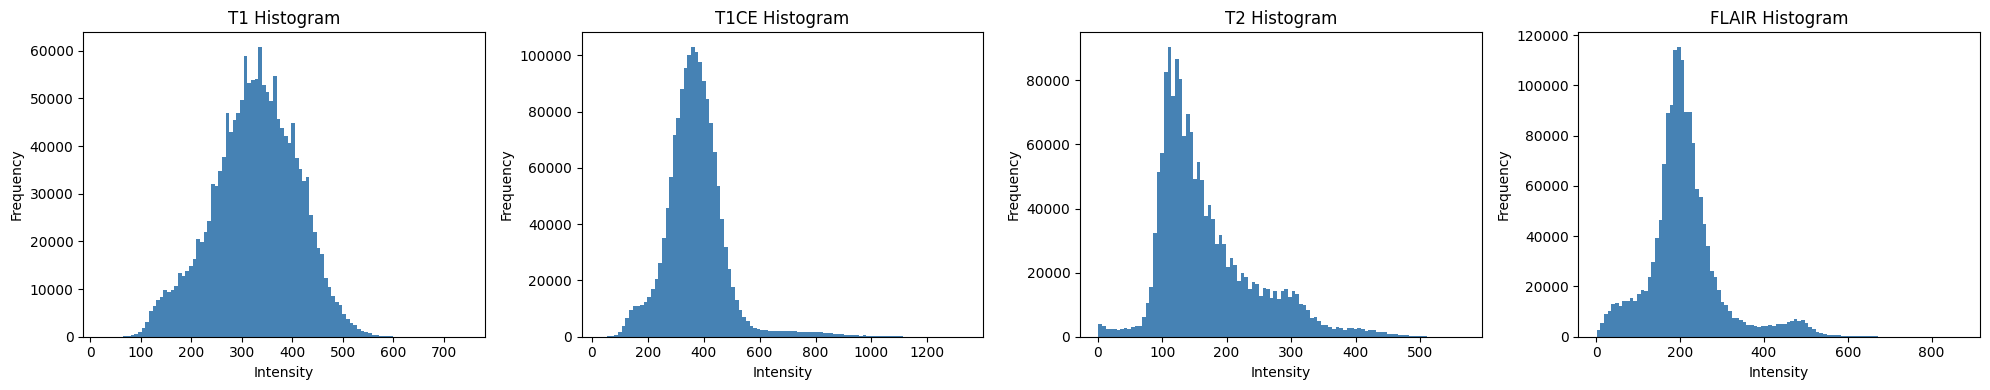

In [46]:
# Load volumes for the sample subject (already defined earlier as sample_id)
volumes = {}
sample_path = os.path.join(data_dir, sample_id)

for mod in modalities:
    path = os.path.join(sample_path, f"{sample_id}_{mod}.nii")
    volumes[mod] = nib.load(path).get_fdata()

# Plot histograms and print stats
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, mod in enumerate(modalities):
    data = volumes[mod]
    non_zero = data[data > 0]

    axes[i].hist(non_zero.ravel(), bins=100, color='steelblue')
    axes[i].set_title(f"{mod.upper()} Histogram")
    axes[i].set_xlabel("Intensity")
    axes[i].set_ylabel("Frequency")

    print(f"{mod.upper()} — Mean: {np.mean(non_zero):.2f}, Std: {np.std(non_zero):.2f}, "
          f"Min: {np.min(non_zero):.2f}, Max: {np.max(non_zero):.2f}")

plt.tight_layout()
plt.show()


Summary:

- **T1** shows brain structure with a tight, consistent range  
- **T1ce** has higher intensity regions from contrast enhancement (useful for tumors)  
- **T2** highlights fluid-filled areas like ventricles or swelling  
- **FLAIR** filters out fluid and is great for spotting lesions

These differences are important — we’ll normalize each modality separately and keep all four as input channels.



### Section 2.3: Visualising Central Slices (Axial, Coronal, Sagittal)

To get a better visual sense of each scan, we look at three views:

- Axial (top-down)
- Coronal (front)
- Sagittal (side)

This shows us the scan orientation and how each modality captures structure.


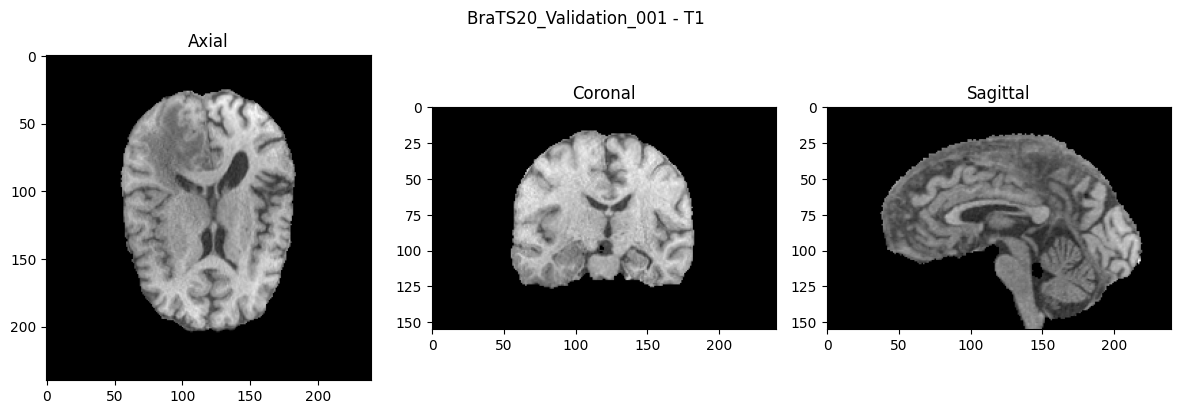

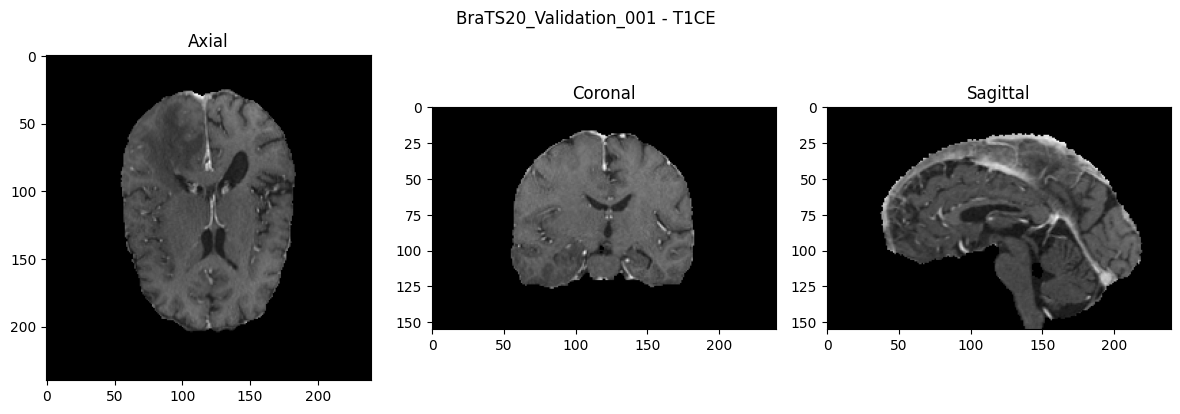

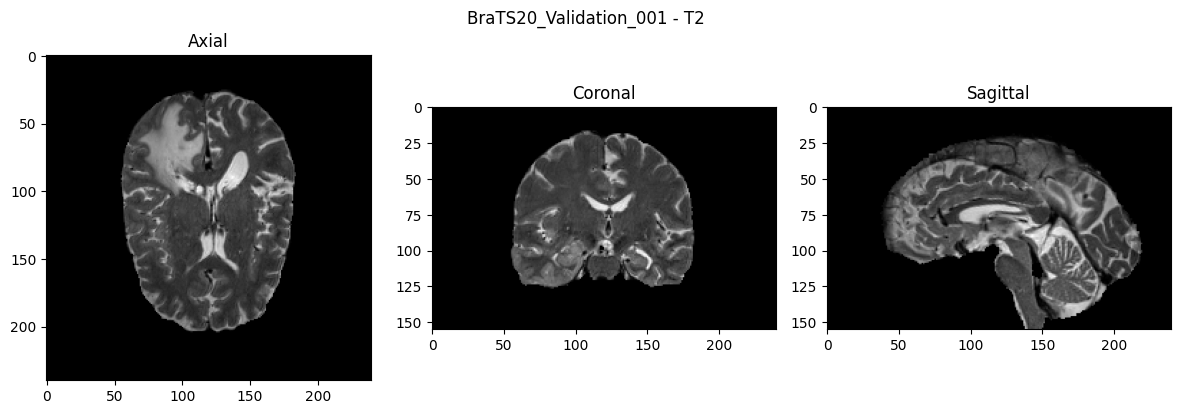

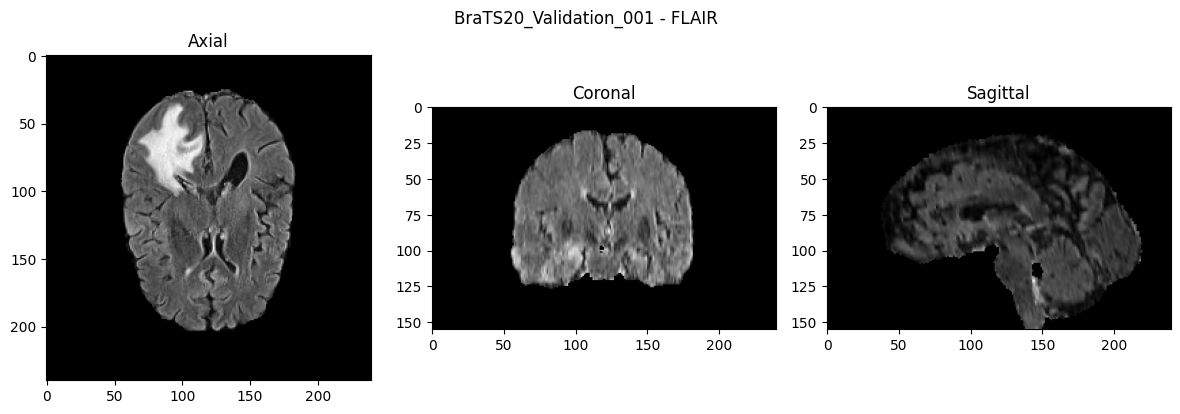

In [47]:
# Define a function to plot central slices from all 3 axes
def show_slices(volume, title):
    # Create a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Axial slice = XY plane at middle Z position
    axes[0].imshow(np.rot90(volume[:, :, volume.shape[2] // 2]), cmap='gray')
    axes[0].set_title('Axial')

    # Coronal slice = XZ plane at middle Y position
    axes[1].imshow(np.rot90(volume[:, volume.shape[1] // 2, :]), cmap='gray')
    axes[1].set_title('Coronal')

    # Sagittal slice = YZ plane at middle X position
    axes[2].imshow(np.rot90(volume[volume.shape[0] // 2, :, :]), cmap='gray')
    axes[2].set_title('Sagittal')

    # Add overall title and format the plot
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Loop through each modality and display its three central slices
for mod in modalities:
    show_slices(volumes[mod], f"{sample_id} - {mod.upper()}")


### Section 3 Visual Comparrison of 3D scans across Modalaties



# Apply to both modalities
x1, y1, z1, val1 = preprocess_for_3d(volumes['flair'])
x2, y2, z2, val2 = preprocess_for_3d(volumes['t1ce'])
x3, y3, z3, val3 = preprocess_for_3d(volumes['t1'])
x4, y4, z4, val4 = preprocess_for_3d(volumes['t2'])

# Create subplot figure with both
fig = go.Figure()

# plot the Flair Overlay 
fig.add_trace(go.Scatter3d(
    x=x1, y=y1, z=z1,
    mode='markers',
    marker=dict(size=1.5, color=val1, colorscale='Viridis', opacity=0.5),
    name='FLAIR'
))

fig.add_trace(go.Scatter3d(
    x=x2, y=y2, z=z2,
    mode='markers',
    marker=dict(size=1.5, color=val2, colorscale='plotly3', opacity=0.5),
    name='T1ce'
))

fig.add_trace(go.Scatter3d(
    x=x3, y=y3, z=z3,
    mode='markers',
    marker=dict(size=1.5, color=val3, colorscale='cividis', opacity=0.5),
    name='T1'
))

fig.add_trace(go.Scatter3d(
    x=x4, y=y4, z=z4,
    mode='markers',
    marker=dict(size=1.5, color=val4, colorscale='turbo', opacity=0.5),
    name='T2'
))

fig.update_layout(
    title=f"3D Comparison – FLAIR vs T1ce vs T1 vs T2 ({sample_id})",
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.8, y=0.9)
)

fig.show()


In [51]:

# Normalize and threshold each modality
def preprocess_for_3d(volume, threshold=0.4, subsample_rate=2):  # default added here
    norm = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    mask = norm > threshold
    subsample = (slice(None, None, subsample_rate),
                 slice(None, None, subsample_rate),
                 slice(None, None, subsample_rate))
    vol = norm[subsample]
    m = mask[subsample]
    x, y, z = np.where(m)
    values = vol[x, y, z]
    return x, y, z, values

## List of modalities to pick from
modalities_list = ['flair', 't1ce', 't1', 't2']
colorscale_map = {
    'flair': 'Viridis',
    't1ce': 'plotly3',
    't1': 'cividis',
    't2': 'turbo'
}

# Function to generate the 3D plot
def plot_modal(modality='flair', threshold=0.4, subsample_rate=2, marker_size=2, opacity=0.5):
    # Normalize and threshold the volume
    vol = volumes[modality]
    norm = (vol - np.min(vol)) / (np.max(vol) - np.min(vol))
    mask = norm > threshold
    subsample = (slice(None, None, subsample_rate),
                 slice(None, None, subsample_rate),
                 slice(None, None, subsample_rate))
    vol_sub = norm[subsample]
    mask_sub = mask[subsample]
    x, y, z = np.where(mask_sub)
    val = vol_sub[x, y, z]

    # Create plot
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=marker_size, color=val, colorscale=colorscale_map[modality], opacity=opacity),
        name=modality.upper()
    ))

    fig.update_layout(
        title=f"Interactive 3D MRI — {modality.upper()} | Threshold={threshold} | Subsample={subsample_rate}",
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    fig.show()

# Widgets
modality_dropdown = widgets.Dropdown(options=modalities_list, value='flair', description='Modality:')
threshold_slider = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.05, description='Threshold:')
subsample_slider = widgets.IntSlider(value=2, min=1, max=6, step=1, description='Subsample:')
marker_slider = widgets.IntSlider(value=2, min=1, max=5, step=1, description='Marker Size:')
opacity_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='Opacity:')

# Display widget interaction
widgets.interact(
    plot_modal,
    modality=modality_dropdown,
    threshold=threshold_slider,
    subsample_rate=subsample_slider,
    marker_size=marker_slider,
    opacity=opacity_slider
)

interactive(children=(Dropdown(description='Modality:', options=('flair', 't1ce', 't1', 't2'), value='flair'),…

<function __main__.plot_modal(modality='flair', threshold=0.4, subsample_rate=2, marker_size=2, opacity=0.5)>